# Method 2 - Best Minus Rest Top 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 5].copy()                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

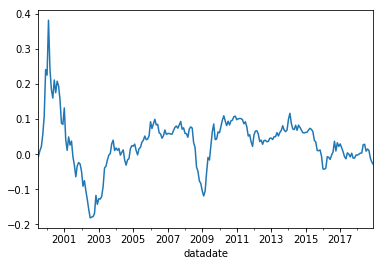

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.241307
2000-12-31   -0.125976
2001-12-31   -0.104379
2002-12-31   -0.118108
2003-12-31    0.179072
2004-12-31    0.013706
2005-12-31    0.027675
2006-12-31    0.003797
2007-12-31    0.017634
2008-12-31   -0.147906
2009-12-31    0.160790
2010-12-31    0.042264
2011-12-31   -0.077725
2012-12-31    0.022607
2013-12-31    0.022456
2014-12-31   -0.007560
2015-12-31   -0.062582
2016-12-31    0.027845
2017-12-31   -0.024150
2018-12-31   -0.026547
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     116.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.76e-54
Time:                        01:17:18   Log-Likelihood:                 669.94
No. Observations:                 234   AIC:                            -1330.
Df Residuals:                     229   BIC:                            -1313.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.590      0.556      -0.001       0.002
mktrf          0.1024      0.026      3.932      0.000       0.051       0.154
me             0.2388      0.030      7.882      0.000       0.179       0.299
ia            -0.3141      0.046     -6.822      0.000      -0.405      -0.223
roe           -0.3067      0.039     -7.781      0.000      -0.384      -0.229
==============================================================================
Omnibus:                       40.536   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.318
Skew:                           0.604   Prob(JB):                     3.43e-36
Kurtosis:                       6.911   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     40.80
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.50e-26
Time:                        01:17:18   Log-Likelihood:                 669.94
No. Observations:                 234   AIC:                            -1330.
Df Residuals:                     229   BIC:                            -1313.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.540      0.589      -0.001       0.003
mktrf          0.1024      0.031      3.347      0.001       0.042       0.162
me             0.2388      0.058      4.109      0.000       0.125       0.353
ia            -0.3141      0.085     -3.692      0.000      -0.481      -0.147
roe           -0.3067      0.062     -4.928      0.000      -0.429      -0.185
==============================================================================
Omnibus:                       40.536   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.318
Skew:                           0.604   Prob(JB):                     3.43e-36
Kurtosis:                       6.911   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     55.21
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.52e-32
Time:                        01:17:18   Log-Likelihood:                 669.94
No. Observations:                 234   AIC:                            -1330.
Df Residuals:                     229   BIC:                            -1313.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.575      0.565      -0.001       0.002
mktrf          0.1024      0.028      3.707      0.000       0.048       0.157
me             0.2388      0.058      4.103      0.000       0.125       0.353
ia            -0.3141      0.085     -3.679      0.000      -0.481      -0.147
roe           -0.3067      0.066     -4.646      0.000      -0.436      -0.177
==============================================================================
Omnibus:                       40.536   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.318
Skew:                           0.604   Prob(JB):                     3.43e-36
Kurtosis:                       6.911   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     112.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.73e-59
Time:                        01:17:18   Log-Likelihood:                 685.59
No. Observations:                 234   AIC:                            -1359.
Df Residuals:                     228   BIC:                            -1338.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.024      0.307      -0.001       0.003
mktrf          0.1128      0.024      4.611      0.000       0.065       0.161
smb            0.2142      0.032      6.636      0.000       0.151       0.278
hml           -0.0723      0.038     -1.900      0.059      -0.147       0.003
rmw           -0.3825      0.043     -8.887      0.000      -0.467      -0.298
cma           -0.0991      0.055     -1.812      0.071      -0.207       0.009
==============================================================================
Omnibus:                       30.734   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.278
Skew:                           0.530   Prob(JB):                     6.77e-20
Kurtosis:                       5.816   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     41.43
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.08e-30
Time:                        01:17:18   Log-Likelihood:                 685.59
No. Observations:                 234   AIC:                            -1359.
Df Residuals:                     228   BIC:                            -1338.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      0.985      0.325      -0.001       0.003
mktrf          0.1128      0.027      4.184      0.000       0.060       0.166
smb            0.2142      0.032      6.721      0.000       0.152       0.277
hml           -0.0723      0.066     -1.092      0.275      -0.202       0.057
rmw           -0.3825      0.053     -7.212      0.000      -0.486      -0.279
cma           -0.0991      0.064     -1.551      0.121      -0.224       0.026
==============================================================================
Omnibus:                       30.734   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.278
Skew:                           0.530   Prob(JB):                     6.77e-20
Kurtosis:                       5.816   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     54.46
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.68e-37
Time:                        01:17:18   Log-Likelihood:                 685.59
No. Observations:                 234   AIC:                            -1359.
Df Residuals:                     228   BIC:                            -1338.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.001      1.046      0.295      -0.001       0.003
mktrf          0.1128      0.029      3.840      0.000       0.055       0.170
smb            0.2142      0.033      6.548      0.000       0.150       0.278
hml           -0.0723      0.055     -1.322      0.186      -0.180       0.035
rmw           -0.3825      0.048     -7.904      0.000      -0.477      -0.288
cma           -0.0991      0.056     -1.761      0.078      -0.209       0.011
==============================================================================
Omnibus:                       30.734   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.278
Skew:                           0.530   Prob(JB):                     6.77e-20
Kurtosis:                       5.816   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     94.07
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.35e-47
Time:                        01:17:18   Log-Likelihood:                 653.95
No. Observations:                 234   AIC:                            -1298.
Df Residuals:                     229   BIC:                            -1281.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -1.098      0.273      -0.003       0.001
mktrf          0.2055      0.026      8.001      0.000       0.155       0.256
smb            0.3473      0.032     10.836      0.000       0.284       0.410
hml           -0.1868      0.032     -5.866      0.000      -0.250      -0.124
umd           -0.0416      0.021     -1.992      0.048      -0.083      -0.000
==============================================================================
Omnibus:                       38.802   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.337
Skew:                           0.717   Prob(JB):                     2.21e-23
Kurtosis:                       5.940   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     42.03
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.08e-26
Time:                        01:17:18   Log-Likelihood:                 653.95
No. Observations:                 234   AIC:                            -1298.
Df Residuals:                     229   BIC:                            -1281.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -1.149      0.251      -0.003       0.001
mktrf          0.2055      0.037      5.547      0.000       0.133       0.278
smb            0.3473      0.053      6.505      0.000       0.243       0.452
hml           -0.1868      0.056     -3.322      0.001      -0.297      -0.077
umd           -0.0416      0.042     -1.001      0.317      -0.123       0.040
==============================================================================
Omnibus:                       38.802   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.337
Skew:                           0.717   Prob(JB):                     2.21e-23
Kurtosis:                       5.940   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     43.74
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.00e-27
Time:                        01:17:18   Log-Likelihood:                 653.95
No. Observations:                 234   AIC:                            -1298.
Df Residuals:                     229   BIC:                            -1281.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -1.299      0.194      -0.003       0.001
mktrf          0.2055      0.039      5.308      0.000       0.130       0.281
smb            0.3473      0.049      7.160      0.000       0.252       0.442
hml           -0.1868      0.059     -3.183      0.001      -0.302      -0.072
umd           -0.0416      0.040     -1.044      0.297      -0.120       0.037
==============================================================================
Omnibus:                       38.802   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.337
Skew:                           0.717   Prob(JB):                     2.21e-23
Kurtosis:                       5.940   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     65.76
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.86e-29
Time:                        01:17:18   Log-Likelihood:                 319.81
No. Observations:                 120   AIC:                            -629.6
Df Residuals:                     115   BIC:                            -615.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.793      0.430      -0.002       0.005
mktrf          0.1553      0.044      3.503      0.001       0.067       0.243
me             0.2595      0.044      5.927      0.000       0.173       0.346
ia            -0.4195      0.069     -6.117      0.000      -0.555      -0.284
roe           -0.2043      0.061     -3.366      0.001      -0.324      -0.084
==============================================================================
Omnibus:                       13.266   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               26.487
Skew:                           0.413   Prob(JB):                     1.77e-06
Kurtosis:                       5.148   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     27.97
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.15e-16
Time:                        01:17:18   Log-Likelihood:                 319.81
No. Observations:                 120   AIC:                            -629.6
Df Residuals:                     115   BIC:                            -615.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.697      0.486      -0.002       0.005
mktrf          0.1553      0.049      3.162      0.002       0.059       0.252
me             0.2595      0.076      3.426      0.001       0.111       0.408
ia            -0.4195      0.106     -3.974      0.000      -0.626      -0.213
roe           -0.2043      0.092     -2.231      0.026      -0.384      -0.025
==============================================================================
Omnibus:                       13.266   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               26.487
Skew:                           0.413   Prob(JB):                     1.77e-06
Kurtosis:                       5.148   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     39.87
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.51e-21
Time:                        01:17:18   Log-Likelihood:                 319.81
No. Observations:                 120   AIC:                            -629.6
Df Residuals:                     115   BIC:                            -615.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.736      0.462      -0.002       0.005
mktrf          0.1553      0.040      3.878      0.000       0.077       0.234
me             0.2595      0.078      3.314      0.001       0.106       0.413
ia            -0.4195      0.099     -4.225      0.000      -0.614      -0.225
roe           -0.2043      0.092     -2.224      0.026      -0.384      -0.024
==============================================================================
Omnibus:                       13.266   Durbin-Watson:                   2.082
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               26.487
Skew:                           0.413   Prob(JB):                     1.77e-06
Kurtosis:                       5.148   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     73.65
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.46e-34
Time:                        01:17:19   Log-Likelihood:                 334.95
No. Observations:                 120   AIC:                            -657.9
Df Residuals:                     114   BIC:                            -641.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      1.718      0.088      -0.000       0.006
mktrf          0.1584      0.041      3.826      0.000       0.076       0.240
smb            0.2138      0.047      4.561      0.000       0.121       0.307
hml           -0.1502      0.057     -2.614      0.010      -0.264      -0.036
rmw           -0.3090      0.068     -4.561      0.000      -0.443      -0.175
cma           -0.1009      0.074     -1.360      0.176      -0.248       0.046
==============================================================================
Omnibus:                        9.353   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               14.095
Skew:                           0.359   Prob(JB):                     0.000870
Kurtosis:                       4.518   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     34.59
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.24e-21
Time:                        01:17:19   Log-Likelihood:                 334.95
No. Observations:                 120   AIC:                            -657.9
Df Residuals:                     114   BIC:                            -641.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      1.964      0.050    5.31e-06       0.005
mktrf          0.1584      0.043      3.725      0.000       0.075       0.242
smb            0.2138      0.045      4.742      0.000       0.125       0.302
hml           -0.1502      0.075     -2.014      0.044      -0.296      -0.004
rmw           -0.3090      0.076     -4.082      0.000      -0.457      -0.161
cma           -0.1009      0.081     -1.244      0.214      -0.260       0.058
==============================================================================
Omnibus:                        9.353   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               14.095
Skew:                           0.359   Prob(JB):                     0.000870
Kurtosis:                       4.518   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     43.86
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.02e-25
Time:                        01:17:19   Log-Likelihood:                 334.95
No. Observations:                 120   AIC:                            -657.9
Df Residuals:                     114   BIC:                            -641.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      2.098      0.036       0.000       0.005
mktrf          0.1584      0.041      3.825      0.000       0.077       0.240
smb            0.2138      0.046      4.630      0.000       0.123       0.304
hml           -0.1502      0.059     -2.534      0.011      -0.266      -0.034
rmw           -0.3090      0.075     -4.128      0.000      -0.456      -0.162
cma           -0.1009      0.070     -1.441      0.150      -0.238       0.036
==============================================================================
Omnibus:                        9.353   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               14.095
Skew:                           0.359   Prob(JB):                     0.000870
Kurtosis:                       4.518   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     72.75
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.33e-30
Time:                        01:17:19   Log-Likelihood:                 324.10
No. Observations:                 120   AIC:                            -638.2
Df Residuals:                     115   BIC:                            -624.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.378      0.706      -0.002       0.004
mktrf          0.2864      0.038      7.598      0.000       0.212       0.361
smb            0.3030      0.043      7.062      0.000       0.218       0.388
hml           -0.2545      0.043     -5.921      0.000      -0.340      -0.169
umd            0.0017      0.026      0.063      0.950      -0.051       0.054
==============================================================================
Omnibus:                        6.271   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                7.869
Skew:                           0.271   Prob(JB):                       0.0196
Kurtosis:                       4.131   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     43.58
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.26e-22
Time:                        01:17:19   Log-Likelihood:                 324.10
No. Observations:                 120   AIC:                            -638.2
Df Residuals:                     115   BIC:                            -624.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.422      0.673      -0.002       0.003
mktrf          0.2864      0.044      6.436      0.000       0.199       0.374
smb            0.3030      0.060      5.047      0.000       0.185       0.421
hml           -0.2545      0.052     -4.873      0.000      -0.357      -0.152
umd            0.0017      0.042      0.039      0.969      -0.081       0.084
==============================================================================
Omnibus:                        6.271   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                7.869
Skew:                           0.271   Prob(JB):                       0.0196
Kurtosis:                       4.131   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     55.77
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.58e-26
Time:                        01:17:19   Log-Likelihood:                 324.10
No. Observations:                 120   AIC:                            -638.2
Df Residuals:                     115   BIC:                            -624.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.498      0.618      -0.002       0.003
mktrf          0.2864      0.035      8.088      0.000       0.217       0.356
smb            0.3030      0.052      5.868      0.000       0.202       0.404
hml           -0.2545      0.042     -6.061      0.000      -0.337      -0.172
umd            0.0017      0.036      0.047      0.963      -0.068       0.071
==============================================================================
Omnibus:                        6.271   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.043   Jarque-Bera (JB):                7.869
Skew:                           0.271   Prob(JB):                       0.0196
Kurtosis:                       4.131   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     68.37
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.75e-29
Time:                        01:17:19   Log-Likelihood:                 393.56
No. Observations:                 114   AIC:                            -777.1
Df Residuals:                     109   BIC:                            -763.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.286      0.776      -0.001       0.002
mktrf          0.0542      0.023      2.351      0.021       0.008       0.100
me             0.1955      0.036      5.494      0.000       0.125       0.266
ia            -0.0790      0.049     -1.602      0.112      -0.177       0.019
roe           -0.4455      0.043    -10.274      0.000      -0.531      -0.360
==============================================================================
Omnibus:                        5.930   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.722
Skew:                           0.400   Prob(JB):                       0.0572
Kurtosis:                       3.751   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     46.87
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.36e-23
Time:                        01:17:19   Log-Likelihood:                 393.56
No. Observations:                 114   AIC:                            -777.1
Df Residuals:                     109   BIC:                            -763.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.381      0.703      -0.001       0.001
mktrf          0.0542      0.024      2.216      0.027       0.006       0.102
me             0.1955      0.026      7.470      0.000       0.144       0.247
ia            -0.0790      0.063     -1.253      0.210      -0.203       0.045
roe           -0.4455      0.062     -7.200      0.000      -0.567      -0.324
==============================================================================
Omnibus:                        5.930   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.722
Skew:                           0.400   Prob(JB):                       0.0572
Kurtosis:                       3.751   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     55.27
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.23e-25
Time:                        01:17:19   Log-Likelihood:                 393.56
No. Observations:                 114   AIC:                            -777.1
Df Residuals:                     109   BIC:                            -763.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.402      0.688      -0.001       0.001
mktrf          0.0542      0.024      2.248      0.025       0.007       0.101
me             0.1955      0.028      7.091      0.000       0.141       0.249
ia            -0.0790      0.072     -1.102      0.271      -0.220       0.062
roe           -0.4455      0.057     -7.786      0.000      -0.558      -0.333
==============================================================================
Omnibus:                        5.930   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.722
Skew:                           0.400   Prob(JB):                       0.0572
Kurtosis:                       3.751   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     29.71
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.13e-19
Time:                        01:17:19   Log-Likelihood:                 371.32
No. Observations:                 114   AIC:                            -730.6
Df Residuals:                     108   BIC:                            -714.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.510      0.611      -0.002       0.001
mktrf          0.0781      0.027      2.911      0.004       0.025       0.131
smb            0.2315      0.044      5.313      0.000       0.145       0.318
hml            0.0281      0.056      0.505      0.614      -0.082       0.138
rmw           -0.3508      0.068     -5.157      0.000      -0.486      -0.216
cma           -0.0234      0.086     -0.270      0.787      -0.195       0.148
==============================================================================
Omnibus:                        3.338   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                3.000
Skew:                           0.396   Prob(JB):                        0.223
Kurtosis:                       3.064   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     24.06
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.37e-16
Time:                        01:17:19   Log-Likelihood:                 371.32
No. Observations:                 114   AIC:                            -730.6
Df Residuals:                     108   BIC:                            -714.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.559      0.576      -0.002       0.001
mktrf          0.0781      0.026      2.999      0.003       0.027       0.129
smb            0.2315      0.037      6.174      0.000       0.158       0.305
hml            0.0281      0.077      0.364      0.716      -0.123       0.179
rmw           -0.3508      0.094     -3.749      0.000      -0.534      -0.167
cma           -0.0234      0.094     -0.247      0.805      -0.208       0.162
==============================================================================
Omnibus:                        3.338   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                3.000
Skew:                           0.396   Prob(JB):                        0.223
Kurtosis:                       3.064   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     34.53
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.11e-21
Time:                        01:17:19   Log-Likelihood:                 371.32
No. Observations:                 114   AIC:                            -730.6
Df Residuals:                     108   BIC:                            -714.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.640      0.522      -0.002       0.001
mktrf          0.0781      0.026      3.060      0.002       0.028       0.128
smb            0.2315      0.037      6.228      0.000       0.159       0.304
hml            0.0281      0.083      0.338      0.735      -0.135       0.191
rmw           -0.3508      0.085     -4.108      0.000      -0.518      -0.183
cma           -0.0234      0.115     -0.203      0.839      -0.249       0.203
==============================================================================
Omnibus:                        3.338   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.188   Jarque-Bera (JB):                3.000
Skew:                           0.396   Prob(JB):                        0.223
Kurtosis:                       3.064   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     28.28
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.07e-16
Time:                        01:17:19   Log-Likelihood:                 362.59
No. Observations:                 114   AIC:                            -715.2
Df Residuals:                     109   BIC:                            -701.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.829      0.409      -0.003       0.001
mktrf          0.0915      0.029      3.193      0.002       0.035       0.148
smb            0.3154      0.045      7.060      0.000       0.227       0.404
hml            0.0304      0.046      0.661      0.510      -0.061       0.122
umd           -0.1020      0.035     -2.940      0.004      -0.171      -0.033
==============================================================================
Omnibus:                        7.135   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.951
Skew:                           0.393   Prob(JB):                       0.0188
Kurtosis:                       4.028   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     25.90
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.26e-15
Time:                        01:17:19   Log-Likelihood:                 362.59
No. Observations:                 114   AIC:                            -715.2
Df Residuals:                     109   BIC:                            -701.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -1.164      0.245      -0.002       0.001
mktrf          0.0915      0.027      3.344      0.001       0.038       0.145
smb            0.3154      0.042      7.571      0.000       0.234       0.397
hml            0.0304      0.082      0.371      0.711      -0.130       0.191
umd           -0.1020      0.034     -2.977      0.003      -0.169      -0.035
==============================================================================
Omnibus:                        7.135   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.951
Skew:                           0.393   Prob(JB):                       0.0188
Kurtosis:                       4.028   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     37.89
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.74e-20
Time:                        01:17:19   Log-Likelihood:                 362.59
No. Observations:                 114   AIC:                            -715.2
Df Residuals:                     109   BIC:                            -701.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -1.345      0.179      -0.002       0.000
mktrf          0.0915      0.026      3.529      0.000       0.041       0.142
smb            0.3154      0.033      9.688      0.000       0.252       0.379
hml            0.0304      0.088      0.347      0.729      -0.141       0.202
umd           -0.1020      0.031     -3.291      0.001      -0.163      -0.041
==============================================================================
Omnibus:                        7.135   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.951
Skew:                           0.393   Prob(JB):                       0.0188
Kurtosis:                       4.028   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""